In [250]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

## Task 1
We load the forest covertype dataset into a pandas dataframe.

In [251]:
df = pd.read_csv("covtype.csv", sep=',')

## Task 2
We then plot the class distribution of the target variable 'Cover_Type' in the form of a histogram. The plot tells us that the distribution is highly skewed in favor of two of the seven classes (imbalanced). As we have less data for the remaining five classes we should expect to see lower prediction accuracy for these. 

c:\Users\aujo8\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 251'. Pick better value with 'binwidth'.


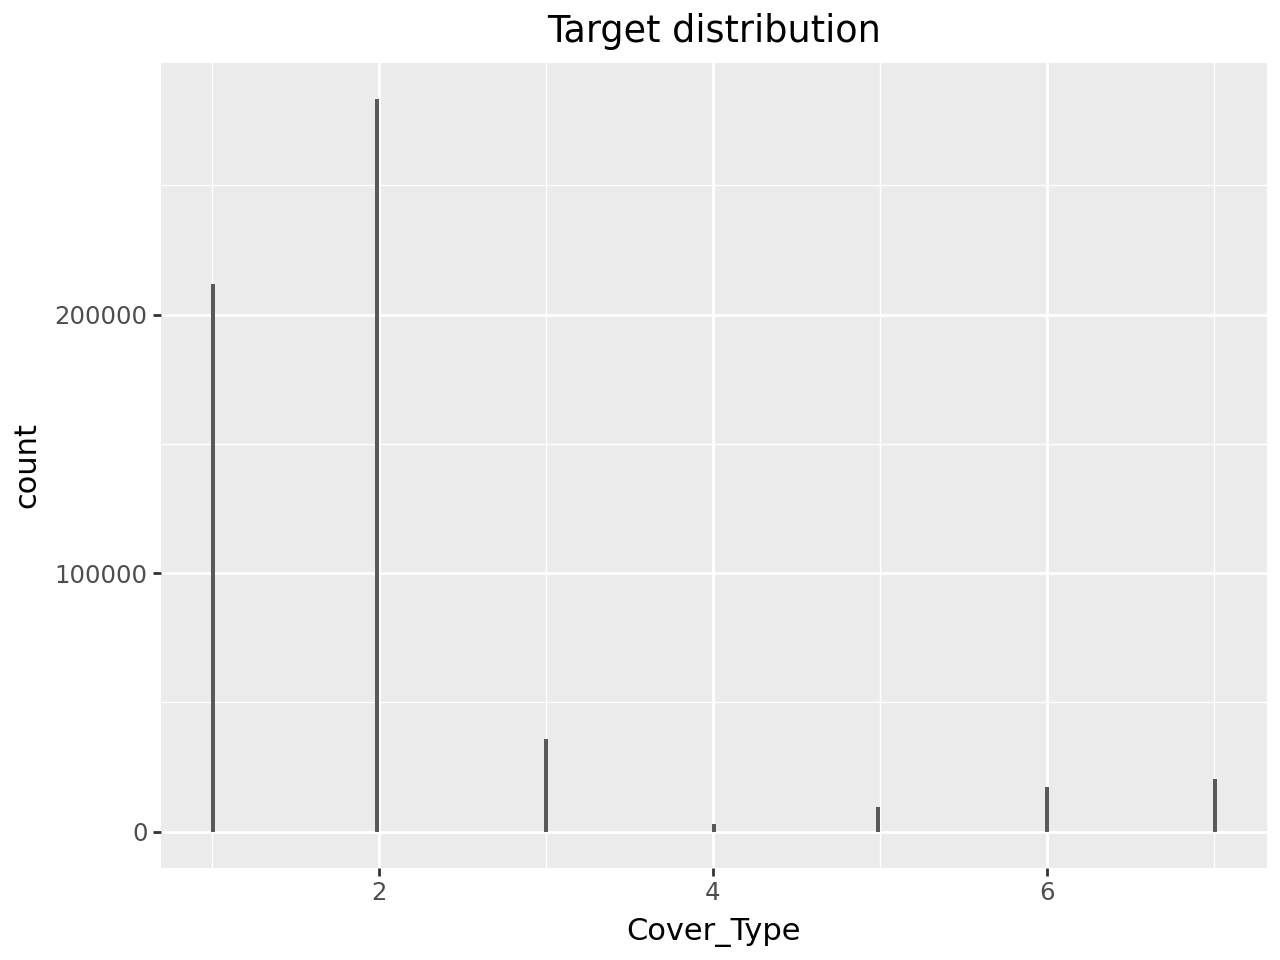

In [252]:
ggplot(df, aes(x="Cover_Type")) +\
    geom_histogram() +\
    ggtitle("Target distribution")

## Task 3
Below we have created a function that standardizes the columns of whatever data it is given. As will become evident from the following tasks we don't actually perform the standardization just yet.

In [253]:
def standardize(data):
    m = np.mean(data, axis=0)
    s = np.std(data, axis=0)
    strd_data = (data - m)/s
    return strd_data

## Task 4
Improves stability.

The standardization should take place **after** the split into training, validation and test data. This is because the mean and standard deviation might no longer be entirely representative for the subsets of data if they are calculated using the whole dataset. In our case, it probably doesn't make a lot of difference, due to the large sizes of even the subsets, but in order to follow good practice, we split the data first.

## Task 5
We will now go ahead and split the data into training, validation and test. After that, we perform the standardization of the numerical features (the first ten columns) of each subset separately. We also split each subset into input variables X and target variables y. When creating the target variables y we also go ahead and convert them into 1x7 indicator vectors such that position *i* is equal to 1 if that observation belongs to covertype number *i* and 0 otherwise.

In [254]:
train, testval = train_test_split(df, test_size=0.2, random_state=19970128)
test, val = train_test_split(testval, test_size=0.5, random_state=19970128)

In [255]:
# standardizing the non-categorical features (the first ten features)
# also seperating the data into targets y and input features X
X_train = pd.concat([standardize(train.iloc[:, 0:10]), train.iloc[:, 10:-1]], axis=1)
y_train = pd.get_dummies(train["Cover_Type"], dtype=int)

X_test = pd.concat([standardize(test.iloc[:, 0:10]), test.iloc[:, 10:-1]], axis=1)
y_test = pd.get_dummies(test["Cover_Type"], dtype=int)

X_val = pd.concat([standardize(val.iloc[:, 0:10]), val.iloc[:, 10:-1]], axis=1)
y_val = pd.get_dummies(val["Cover_Type"], dtype=int)

## Task 6
In order to build a neural network and implement its trainin we are going to use the **PyTorch** library. There are several parameters and properties to be adressed when building a neural network. Below are the motivations for each of the choices.

#### Motivation
 - Depth:
 - Width: We follow the heuristic of smoothly increasing the width such that our widest layer should be close to the middle layer of the model, and then a similarly smooth decrease up until the output layer. During class, we were given the 2x heuristic, i.e. increase number of nodes from one layer to the next by 2x.
 - Activation functions: Since we are completely new to building neural nets, introducing non-linearity as simply as possible seems like good practice. We thus settle on the ReLU (rectified linear unit) activation function. 
 - Output function: 
 - 

In [256]:
import os
import torch
from torch.utils.data import DataLoader
from torch import nn

# if possible, running on GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "hip"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [257]:
# transforming our data into tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

X_test_tensor = torch.tensor(X_test.values).float() 
y_test_tensor = torch.tensor(y_test.values).float()

X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).float()

In [258]:
# creating torch datasets in preparation for mini batches
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

# the dataloaders for the mini batches
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [260]:
# defining the neural net
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
# instantiating the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [262]:
epochs = 120
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# per epoch losses
training_loss = []
validation_loss = []

# training/validation loop
for epoch in range(epochs):
    
    # training phase
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (X, y) in enumerate(train_dl):
        # Move data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dl)
    training_loss.append(avg_train_loss)
    print(f"Average training Loss: {avg_train_loss:.4f}")

    # validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dl)
    validation_loss.append(avg_val_loss)
    print(f"Average validation Loss: {avg_val_loss:.4f}\n")


print("Training complete!")

Epoch 1
-------------------------------
Average training Loss: 0.4378
Average validation Loss: 0.3433

Epoch 2
-------------------------------
Average training Loss: 0.3061
Average validation Loss: 0.2716

Epoch 3
-------------------------------
Average training Loss: 0.2508
Average validation Loss: 0.2450

Epoch 4
-------------------------------
Average training Loss: 0.2198
Average validation Loss: 0.2150

Epoch 5
-------------------------------
Average training Loss: 0.1977
Average validation Loss: 0.2006

Epoch 6
-------------------------------
Average training Loss: 0.1828
Average validation Loss: 0.1916

Epoch 7
-------------------------------
Average training Loss: 0.1702
Average validation Loss: 0.1718

Epoch 8
-------------------------------
Average training Loss: 0.1607
Average validation Loss: 0.1649

Epoch 9
-------------------------------
Average training Loss: 0.1525
Average validation Loss: 0.1744

Epoch 10
-------------------------------
Average training Loss: 0.1466
Av

## Task 7
Judging from the training and validation loss plot below:

 - has the training error converged?
    Yes, it is very stable and has settled relatively close to zero.

 - does the validation curve look as expected?
    Yes, the validation looks as expected. Apart from the very beginning (which is still within the margin of error) of the curve, the validation is steadily sitting on top of the training.

 - are there any indications of overfitting?
   No, 

## Task 8


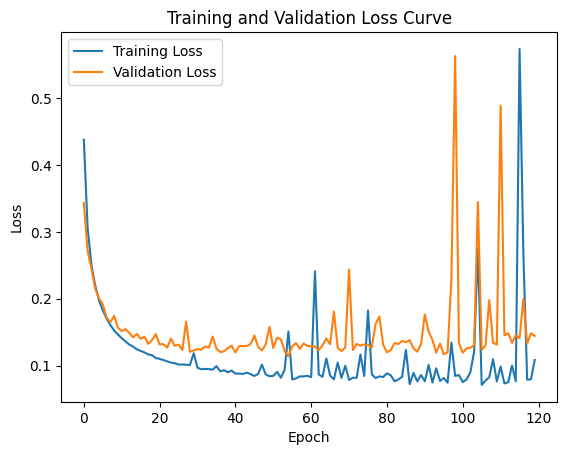

In [263]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.show()

Är det förskjutet ett steg till vänster i träning/validering-kurvan?
Rimlig slutsats utifrån target distribution?
Meningen att man bara ska testa sig fram utifrån tumregler för bredd och djup för NN.
Indexet uppgift 1 fel?
